In [19]:
pip install pandas numpy scikit-learn pymc arviz

Note: you may need to restart the kernel to use updated packages.


In [58]:
import pandas as pd
import numpy as np

# For first-stage multinomial logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# For Bayesian neural network
import pymc as pm
import aesara.tensor as at
import aesara

# For data preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# For model diagnostics
import arviz as az

import pytensor.tensor as pt
import pytensor


# Read the data
data = pd.read_csv('/./Applications/Harvard/sophomore1/bst228/proj/Data/sim_data.csv')


# Display the first few rows
print(data.shape)
print(data.head)

(10000, 103)
<bound method NDFrame.head of             X1        X2        X3        X4        X5        X6        X7  \
0    -1.980572 -1.054986 -0.587028  0.149669  1.024162  0.694136 -1.179325   
1     0.512325  0.463642 -1.770693  0.518597  0.178587  0.623373  1.066866   
2    -2.656774 -0.037894 -0.241204 -0.618496  0.754235  0.714860  0.436825   
3    -0.114331 -0.013974  2.151541 -0.329791 -0.982484  0.438325  0.496986   
4     0.892823  0.028738 -1.329231 -1.214527 -0.547106  0.965226  0.290338   
...        ...       ...       ...       ...       ...       ...       ...   
9995  1.557018  0.478112  0.303498  0.337094  1.547347 -0.498067  0.430487   
9996 -0.282816  0.581349  1.924101 -0.484803  0.499510 -0.667965  0.071849   
9997 -0.822645 -1.007492  1.369003 -0.479798 -0.824473  0.934562  2.218047   
9998 -1.353766  1.247297 -0.138892 -1.028697  1.936285  0.859423 -0.222452   
9999 -0.621887 -0.387801 -1.488961  1.450853 -0.162950  0.164069 -0.989150   

            X8      

## Preprocess

In [59]:
# First-stage target variable: vasopressor choice
first_stage_target = 'T'

# First-stage features: HHI and patient covariates
first_stage_features = [col for col in data.columns if col.startswith('X')] + ['Z']

# Label encode the target variable for logistic regression
label_encoder = LabelEncoder()
data['T_encoded'] = label_encoder.fit_transform(data['T'])

X = data[first_stage_features]
y = data['T_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)


categorical_features = []

numeric_features = X.drop(columns=categorical_features).columns.tolist()

# Preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [60]:
print(numeric_features)
print(categorical_features)


['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100', 'Z']
[]


## First Stage IV Estiamtion

In [61]:
data['T_encoded'] = label_encoder.fit_transform(data['T'])
print(data['T_encoded'])
print(data['T'].value_counts())


0       1
1       3
2       0
3       4
4       0
       ..
9995    1
9996    5
9997    0
9998    0
9999    0
Name: T_encoded, Length: 10000, dtype: int64
T
1    3095
2    1957
5    1545
6    1484
3     987
4     932
Name: count, dtype: int64


In [62]:
from sklearn.model_selection import GridSearchCV
# First-stage multinomial logistic regression

first_stage_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000, class_weight='balanced'))
])
# Define the parameter grid
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'classifier__solver': ['lbfgs', 'saga'],  # Solver
    'classifier__max_iter': [1000, 5000, 10000]  # Maximum iterations
}

# Define the pipeline with GridSearch
grid_search = GridSearchCV(
    first_stage_pipeline,
    param_grid,
    scoring='accuracy',
    cv=5,
    verbose=0,
    n_jobs=-1
)

# Perform the search
grid_search.fit(X_train, y_train)

# Update the pipeline with the best parameters
best_pipeline = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'classifier__C': 100, 'classifier__max_iter': 1000, 'classifier__solver': 'lbfgs'}


In [63]:
# Fit the model
first_stage_pipeline.fit(X_train, y_train)
probabilities = best_pipeline.predict_proba(X)

# Add the probabilities to the data as new columns
data['p0'] = probabilities[:, 0]  # Probability for category 0
data['p1'] = probabilities[:, 1]  # Probability for category 1
data['p2'] = probabilities[:, 2]
data['p3'] = probabilities[:, 3]
data['p4'] = probabilities[:, 4]
data['p5'] = probabilities[:, 5]
assert all((data['p0'] + data['p1'] + data['p2']+ data['p3']+ data['p4'] + data['p5']).round(6) == 1), "Probabilities do not sum to 1 for some rows."

print(data[['p0', 'p1', 'p2']].head())
# Predict the vasopressor choices on the entire dataset
data['predicted_treatment_encoded'] = first_stage_pipeline.predict(X)
data['predicted_treatment'] = label_encoder.inverse_transform(data['predicted_treatment_encoded'])
print("First stage acc: ", sum(data['predicted_treatment']==data['T'])/len(data['T']))

         p0        p1        p2
0  0.134622  0.362697  0.419495
1  0.003033  0.082471  0.304340
2  0.893548  0.099459  0.006644
3  0.000137  0.011244  0.115176
4  0.777085  0.190410  0.029635
First stage acc:  0.5915


In [64]:
print(sum(data['predicted_treatment'] == 1), sum(data['T'] == 1))
print(sum(data['predicted_treatment'] == 2), sum(data['T'] == 2))
print(sum(data['predicted_treatment'] == 3), sum(data['T'] == 3))
print(sum(data['predicted_treatment'] == 4), sum(data['T'] == 4))
print(sum(data['predicted_treatment'] == 5), sum(data['T'] == 5))
print(sum(data['predicted_treatment'] == 6), sum(data['T'] == 6))


2848 3095
1858 1957
1243 987
1124 932
1428 1545
1499 1484


## Bayesian Neural Network

In [65]:
second_stage_target = 'Y'

# Update exclude_cols to include 'predicted_treatment'
exclude_cols = ['T', 'T_encoded', 'Y', 'predicted_treatment', 'Z']

# Define second_stage_features without duplicates
second_stage_features = [col for col in data.columns if col not in exclude_cols]

# Ensure 'predicted_treatment' is only included once
second_stage_features = list(dict.fromkeys(second_stage_features))

# Identify categorical features
categorical_features_second = categorical_features + ['predicted_treatment_encoded']

# Convert categorical variables to category dtype
for col in categorical_features_second:
    data[col] = data[col].astype('category')

# Prepare the data for the second stage
X_second = data[second_stage_features]
y_second = data[second_stage_target]
print(X_second.shape)
numeric_features_second = X_second.drop(columns=categorical_features_second).columns.tolist()
categorical_features_second = X_second.select_dtypes(include=['category']).columns.tolist()

# Preprocessing pipelines
numeric_transformer_second = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer_second = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor_second = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_second, numeric_features_second),
        ('cat', categorical_transformer_second, categorical_features_second)
    ])

# Apply preprocessing
X_second_processed = preprocessor_second.fit_transform(X_second)


# # Apply Ordinal Encoding to categorical features
# ordinal_encoder = OrdinalEncoder()
# X_second[categorical_features_second] = ordinal_encoder.fit_transform(X_second[categorical_features_second])

# # Preprocessing pipeline for numeric features
# numeric_transformer_second = Pipeline(steps=[
#     ('scaler', StandardScaler())
# ])

# preprocessor_second = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer_second, numeric_features_second)
#     ], remainder='passthrough')  

# # Apply preprocessing
# X_second_processed = preprocessor_second.fit_transform(X_second)
# print(X_second_processed.shape)

(10000, 107)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Spike and Slab

In [28]:
print(X_second_processed)

[[ 1.27854371 -0.90035493  1.44068755 ...  0.          0.
   1.        ]
 [ 0.23745516 -1.34216132 -0.31368325 ...  0.          0.
   0.        ]
 [ 1.80205874 -0.31808166 -0.19228165 ...  0.          0.
   0.        ]
 ...
 [-0.63366786 -0.53922544 -0.59636065 ...  0.          0.
   0.        ]
 [ 0.83646247 -0.41784374 -0.71308141 ...  0.          0.
   0.        ]
 [ 0.41372139  1.58815292 -0.77731458 ...  0.          0.
   0.        ]]


In [66]:
import pandas as pd

# Save X_second_processed to a CSV file
pd.DataFrame(X_second_processed).to_csv('sim_X_before.csv', index=False, header=False)
print("X_second_processed saved to 'X_second_processed.csv'")

# Save y_second to a CSV file
pd.DataFrame(y_second).to_csv('sim_Y_before.csv', index=False, header=False)
print("y_second saved to 'y_second.csv'")

X_second_processed saved to 'X_second_processed.csv'
y_second saved to 'y_second.csv'


In [67]:
# Imports
import pymc as pm
import pytensor.tensor as pt
import pytensor

X_shared = pytensor.shared(X_second_processed.astype(np.float32))
y_shared = pytensor.shared(y_second.values.astype(np.int8))

# Define the neural network architecture
n_input = X_second_processed.shape[1]
n_hidden = 10
n_output = 1

with pm.Model() as neural_network:
    # Hyperparameters for spike-and-slab prior
    pi = pm.Beta('pi', alpha=1, beta=4)
    tau = pm.HalfCauchy('tau', beta=1)
    
    # Weights and inclusion indicators for input to hidden layer
    w1 = pm.Normal('w1', mu=0, sigma=tau, shape=(n_input, n_hidden))
    print("Type of w1:", type(w1))
    z1 = pm.Bernoulli('z1', p=pi, shape=(n_input, n_hidden))
    
    # Combine weights and indicators
    w1_combined = w1 * z1
    
    print("Type of X_shared:", type(X_shared))
    print("Shape of X_shared:", X_shared.get_value().shape)

    print("Type of w1_combined:", type(w1_combined))
    if hasattr(w1_combined, 'shape'):
        print("Shape of w1_combined:", w1_combined.shape)
    else:
        print("w1_combined does not have a shape attribute")

    # Bias for hidden layer
    b1 = pm.Normal('b1', mu=0, sigma=1, shape=(n_hidden,))
    
    # Hidden layer
    hidden_pre = pt.dot(X_shared, w1_combined) + b1
    h1 = pt.maximum(hidden_pre, 0)  # ReLU activation
    
    # Weights and inclusion indicators for hidden to output layer
    w2 = pm.Normal('w2', mu=0, sigma=tau, shape=(n_hidden, n_output))
    z2 = pm.Bernoulli('z2', p=pi, shape=(n_hidden, n_output))
    w2_combined = w2 * z2
    
    # Bias for output layer
    b2 = pm.Normal('b2', mu=0, sigma=1, shape=(n_output,))
    
    # Output layer (logits)
    logits = pt.dot(h1, w2_combined) + b2

    # Sigmoid activation for binary outcome
    p = pm.Deterministic('p', pt.sigmoid(pt.flatten(logits)))
    
    # Likelihood (Bernoulli for binary outcome)
    y_obs = pm.Bernoulli('y_obs', p=p, observed=y_shared)
    
    step = pm.NUTS(target_accept=0.9, max_treedepth=15)  # Explicit NUTS configuration
    trace = pm.sample(
        1000,
        tune=1000,
        chains=4,
        cores=4,
        mp_ctx="spawn",
        step=step
    )


Type of w1: <class 'pytensor.tensor.variable.TensorVariable'>
Type of X_shared: <class 'pytensor.tensor.sharedvar.TensorSharedVariable'>
Shape of X_shared: (10000, 112)
Type of w1_combined: <class 'pytensor.tensor.variable.TensorVariable'>
Shape of w1_combined: Shape.0


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [pi, tau, w1, b1, w2, b2]
>BinaryGibbsMetropolis: [z1, z2]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6415 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [69]:
# Save trace as file
az.to_netcdf(trace, "neural_network_trace_sim_1.nc")


'neural_network_trace_sim_1.nc'

In [68]:
print(type(X_shared))
print(type(w1_combined))
print("X_shared shape:", X_shared.get_value().shape)
print("w1_combined shape:", w1_combined.shape)
print("Type of n_input:", type(n_input))
print("Type of n_hidden:", type(n_hidden))



<class 'pytensor.tensor.sharedvar.TensorSharedVariable'>
<class 'pytensor.tensor.variable.TensorVariable'>
X_shared shape: (10000, 112)
w1_combined shape: Shape.0
Type of n_input: <class 'int'>
Type of n_hidden: <class 'int'>


## Diagnostics and Convergence Checks

In [13]:
pip install --upgrade arviz

Note: you may need to restart the kernel to use updated packages.


In [45]:
# Load the saved trace
trace = az.from_netcdf("/Applications/Harvard/sophomore1/bst228/proj/Data/neural_network_trace_sim.nc")

# Print summary or inspect the trace to ensure it's loaded correctly
print(trace)


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data


In [10]:
import arviz as az
print(az.__version__)

0.20.0


      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
pi   0.097  0.023   0.054    0.140      0.001    0.001     284.0     352.0   
tau  0.552  0.122   0.368    0.786      0.033    0.024      12.0      38.0   

     r_hat  
pi    1.01  
tau   1.28  


Sampling: [y_obs]


Output()

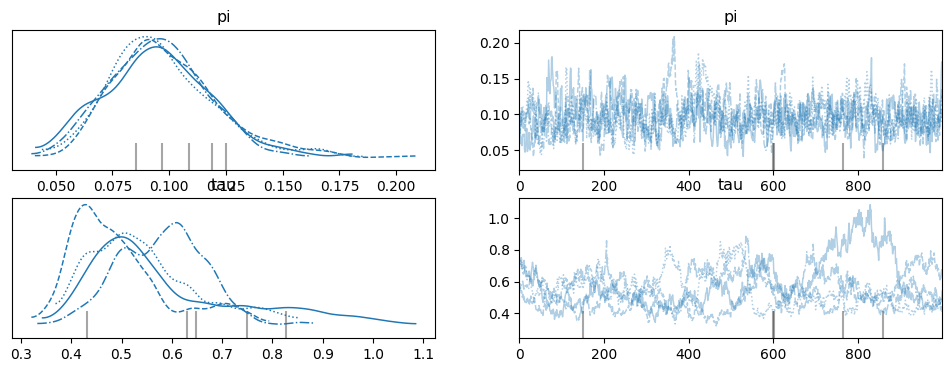

In [70]:
# Summary of the posterior
print(az.summary(trace, var_names=['pi', 'tau']))

# Trace plots
az.plot_trace(trace, var_names=['pi', 'tau'])

# Posterior predictive checks
with pm.Model() as neural_network:
    y_obs = pm.Bernoulli('y_obs', p=p, observed=y_shared)
    ppc = pm.sample_posterior_predictive(trace, var_names=['y_obs'])

array([[<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>]],
      dtype=object)

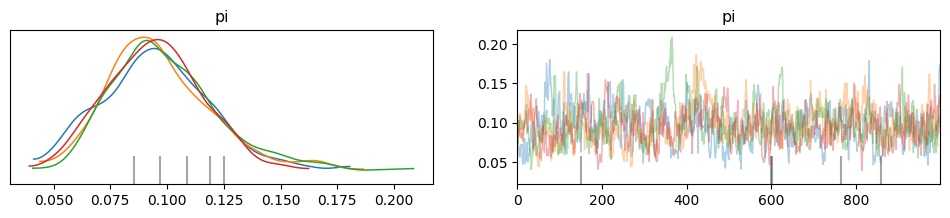

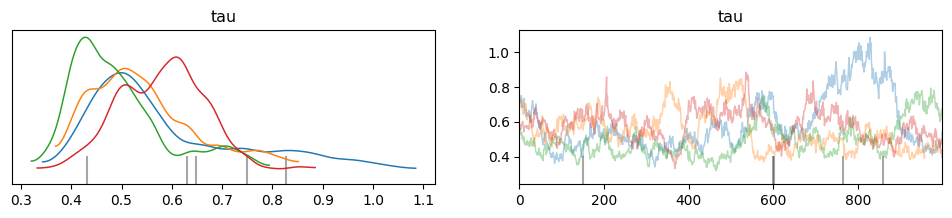

In [71]:
az.plot_trace(trace, var_names=['pi'], compact=False)
az.plot_trace(trace, var_names=['tau'], compact=False)


In [72]:
import arviz as az

posterior = trace.posterior

# Loop through each chain
for chain_id in posterior.chain.values:
    # Use a list for indexing to keep the chain dimension
    chain_data = posterior.isel(chain=[chain_id])
    print(f"Chain {chain_id} summary:")
    chain_summary = az.summary(chain_data, var_names=['pi', 'tau'], round_to=2)
    print(chain_summary)


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Chain 0 summary:
     mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
pi   0.10  0.02    0.05     0.14       0.00     0.00     89.03    152.02   
tau  0.59  0.16    0.38     0.92       0.09     0.07      3.43     21.11   

     r_hat  
pi     NaN  
tau    NaN  
Chain 1 summary:
     mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
pi   0.10  0.02    0.05     0.14       0.00     0.00     38.61     71.59   
tau  0.55  0.11    0.38     0.76       0.06     0.05      2.83     57.78   

     r_hat  
pi     NaN  
tau    NaN  
Chain 2 summary:
     mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
pi   0.10  0.02    0.06     0.15       0.00     0.00     70.20     91.31   
tau  0.49  0.10    0.35     0.71       0.07     0.05      2.12     13.53   

     r_hat  
pi     NaN  
tau    NaN  
Chain 3 summary:
     mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
pi   0.09  0.02    0.06     0.13       0.00     0.00

In [73]:
inference_data = pm.to_inference_data(trace)
if "posterior_predictive" in inference_data._groups:
    del inference_data.posterior_predictive

# Create a new posterior_predictive group
ppc_inference_data = az.from_dict(posterior_predictive={"y_obs": ppc["observed_data"]})

# Add the new posterior_predictive group
inference_data.add_groups({"posterior_predictive": ppc_inference_data.posterior_predictive})

# Verify the updated InferenceData
print(inference_data)

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data


In [74]:
print(ppc)
print(inference_data)
print(inference_data.posterior_predictive)
print(list(inference_data.posterior_predictive.data_vars))
print(list(inference_data.observed_data.data_vars))
# Extract posterior_predictive data
posterior_predictive = inference_data.posterior_predictive

# Flatten the variable structure
posterior_predictive_flat = posterior_predictive.rename({('y_obs', 'y_obs'): 'y_obs'})

# Replace the group in the InferenceData object
inference_data.posterior_predictive = posterior_predictive_flat
print(list(inference_data.posterior_predictive.data_vars))

Inference data with groups:
	> posterior_predictive
	> observed_data
Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
<xarray.Dataset> Size: 160kB
Dimensions:             (chain: 1, draw: 10000)
Coordinates:
  * chain               (chain) int64 8B 0
  * draw                (draw) int64 80kB 0 1 2 3 4 ... 9995 9996 9997 9998 9999
Data variables:
    ('y_obs', 'y_obs')  (chain, draw) int64 80kB 1 0 0 1 0 1 0 ... 0 0 1 1 0 1 1
Attributes:
    created_at:     2024-12-15T05:21:30.307556+00:00
    arviz_version:  0.20.0
[('y_obs', 'y_obs')]
['y_obs']
['y_obs']


<Axes: xlabel='y_obs'>

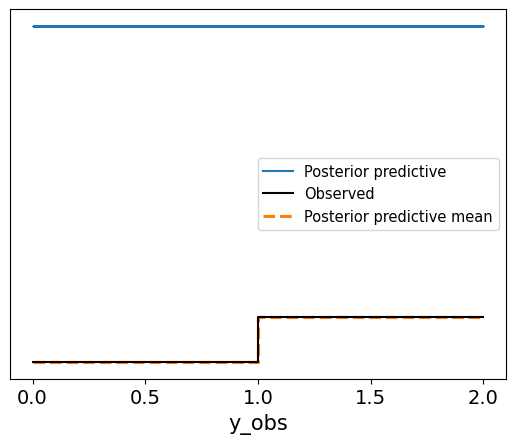

In [75]:

az.plot_ppc(inference_data, group="posterior", var_names=["y_obs"])

## Inference and Interpretation

In [98]:
# Extract the posterior samples of weights and inclusion probabilities
w1_samples = trace.posterior['w1'].stack(samples=("chain", "draw")).values  # Shape: (n_input, n_hidden, n_samples)
z1_samples = trace.posterior['z1'].stack(samples=("chain", "draw")).values  # Shape: (n_input, n_hidden, n_samples)

# Compute feature importance scores by averaging over hidden units and samples
feature_importance_scores = (np.abs(w1_samples) * z1_samples).mean(axis=(1, 2))  # Shape: (n_input,)

# Map back to feature names
feature_names = preprocessor_second.get_feature_names_out()
feature_importance = dict(zip(feature_names, feature_importance_scores))

# Convert feature importance values to a list
importance_values = np.array(list(feature_importance.values()))

# Compute the threshold
threshold = np.percentile(importance_values, 25)  # Top 25% features

# Select features with importance scores above the threshold
selected_features = [feature for feature, score in feature_importance.items() if score >= threshold]

print("Selected Features for Final Neural Network:", len(selected_features))
print(selected_features)



Selected Features for Final Neural Network: 84
['num__X1', 'num__X2', 'num__X3', 'num__X4', 'num__X5', 'num__X6', 'num__X7', 'num__X8', 'num__X9', 'num__X10', 'num__X11', 'num__X12', 'num__X13', 'num__X14', 'num__X15', 'num__X16', 'num__X17', 'num__X20', 'num__X22', 'num__X23', 'num__X24', 'num__X25', 'num__X26', 'num__X28', 'num__X31', 'num__X33', 'num__X34', 'num__X35', 'num__X37', 'num__X38', 'num__X39', 'num__X40', 'num__X42', 'num__X43', 'num__X44', 'num__X45', 'num__X46', 'num__X47', 'num__X51', 'num__X52', 'num__X54', 'num__X55', 'num__X56', 'num__X60', 'num__X62', 'num__X63', 'num__X65', 'num__X66', 'num__X67', 'num__X68', 'num__X70', 'num__X72', 'num__X74', 'num__X76', 'num__X77', 'num__X78', 'num__X81', 'num__X82', 'num__X83', 'num__X84', 'num__X86', 'num__X87', 'num__X88', 'num__X89', 'num__X90', 'num__X91', 'num__X92', 'num__X93', 'num__X94', 'num__X96', 'num__X97', 'num__X100', 'num__p0', 'num__p1', 'num__p2', 'num__p3', 'num__p4', 'num__p5', 'cat__predicted_treatment_enco

In [77]:
print(selected_features)

['num__X1', 'num__X2', 'num__X3', 'num__X4', 'num__X5', 'num__X6', 'num__X7', 'num__X8', 'num__X9', 'num__X10', 'num__X11', 'num__X12', 'num__X13', 'num__X14', 'num__X15', 'num__X16', 'num__X17', 'num__X20', 'num__X22', 'num__X23', 'num__X24', 'num__X25', 'num__X26', 'num__X28', 'num__X31', 'num__X33', 'num__X34', 'num__X35', 'num__X37', 'num__X38', 'num__X39', 'num__X40', 'num__X42', 'num__X43', 'num__X44', 'num__X45', 'num__X46', 'num__X47', 'num__X51', 'num__X52', 'num__X54', 'num__X55', 'num__X56', 'num__X60', 'num__X62', 'num__X63', 'num__X65', 'num__X66', 'num__X67', 'num__X68', 'num__X70', 'num__X72', 'num__X74', 'num__X76', 'num__X77', 'num__X78', 'num__X81', 'num__X82', 'num__X83', 'num__X84', 'num__X86', 'num__X87', 'num__X88', 'num__X89', 'num__X90', 'num__X91', 'num__X92', 'num__X93', 'num__X94', 'num__X96', 'num__X97', 'num__X100', 'num__p0', 'num__p1', 'num__p2', 'num__p3', 'num__p4', 'num__p5', 'cat__predicted_treatment_encoded_0', 'cat__predicted_treatment_encoded_1', '

## Final Neural Network Using Selected Features

In [79]:
# Install Keras Tuner (if not already installed)
!pip install keras-tuner -q

# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt
import numpy as np
import shutil

# Prepare data with selected features
selected_indices = [list(feature_names).index(feat) for feat in selected_features]
p0_index = list(feature_names).index('num__p0')
p1_index = list(feature_names).index('num__p1')
p2_index = list(feature_names).index('num__p2')

p3_index = list(feature_names).index('num__p3')
p4_index = list(feature_names).index('num__p4')
p5_index = list(feature_names).index('num__p5')

final_indices = selected_indices + [p0_index, p1_index, p2_index, p3_index, p4_index, p5_index]

X_final = X_second_processed[:, final_indices]

# Split into training and testing sets
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_final,
    y_second,
    test_size=0.2,
    random_state=777
)

# Define a function to build the model, which Keras Tuner will use
def build_model(hp):
    model = Sequential()
    
    # Define the number of hidden layers and units per layer
    for i in range(hp.Int('num_layers', 1, 5)):
        if i == 0:
            # First layer (input layer)
            model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
                            input_shape=(X_train_final.shape[1],)))
        else:
            # Subsequent layers
            model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32)))
        
        # Optional Batch Normalization
        if hp.Boolean(f'batch_norm_{i}'):
            model.add(BatchNormalization())
        
        # Activation function
        model.add(Activation(hp.Choice(f'activation_{i}', ['relu', 'tanh', 'sigmoid'])))
        
        # Optional Dropout
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model


shutil.rmtree('my_dir/hyperparam_tuning', ignore_errors=True)

# Instantiate the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=30,  # You can adjust this number
    executions_per_trial=1,
    directory='./my_dir',
    project_name='hyperparam_tuning'
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
# Search for the best hyperparameters
tuner.search(
    X_train_final,
    y_train_final,
    epochs=200,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the test set
loss, accuracy = best_model.evaluate(X_test_final, y_test_final)
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions
y_pred_probs = best_model.predict(X_test_final).flatten()
y_pred = (y_pred_probs >= 0.5).astype(int)

# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_final, y_pred, target_names=['Survived', 'Died']))


Trial 30 Complete [00h 00m 05s]
val_accuracy: 0.6993749737739563

Best val_accuracy So Far: 0.7099999785423279
Total elapsed time: 00h 03m 29s
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - accuracy: 0.6897 - loss: 0.5864
Test Accuracy: 0.6930
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step
              precision    recall  f1-score   support

    Survived       0.66      0.70      0.68       931
        Died       0.72      0.69      0.71      1069

    accuracy                           0.69      2000
   macro avg       0.69      0.69      0.69      2000
weighted avg       0.69      0.69      0.69      2000



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [60]:
print(len(y_test_final))
sum(y_test_final)

2000


1461.0

## Save. FinalResult

## Find Best Percentile & Regularization Comparison

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Percentile: 0, Features: 112, Test Accuracy: 0.6810


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Percentile: 5, Features: 106, Test Accuracy: 0.6820


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Percentile: 10, Features: 100, Test Accuracy: 0.7025


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Percentile: 15, Features: 95, Test Accuracy: 0.6905


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Percentile: 20, Features: 89, Test Accuracy: 0.6885


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Percentile: 25, Features: 84, Test Accuracy: 0.6875


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Percentile: 30, Features: 78, Test Accuracy: 0.6855


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Percentile: 35, Features: 73, Test Accuracy: 0.6935


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Percentile: 40, Features: 67, Test Accuracy: 0.7010


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Percentile: 45, Features: 62, Test Accuracy: 0.7055


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Percentile: 50, Features: 56, Test Accuracy: 0.6915


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Percentile: 55, Features: 50, Test Accuracy: 0.6965


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Percentile: 60, Features: 45, Test Accuracy: 0.7000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Percentile: 65, Features: 39, Test Accuracy: 0.6945


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Percentile: 70, Features: 34, Test Accuracy: 0.7050


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Percentile: 75, Features: 28, Test Accuracy: 0.6910


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Percentile: 80, Features: 23, Test Accuracy: 0.7100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Percentile: 85, Features: 19, Test Accuracy: 0.7040


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Percentile: 90, Features: 14, Test Accuracy: 0.6950


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Percentile: 95, Features: 9, Test Accuracy: 0.6670


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Percentile: 100, Features: 6, Test Accuracy: 0.6315


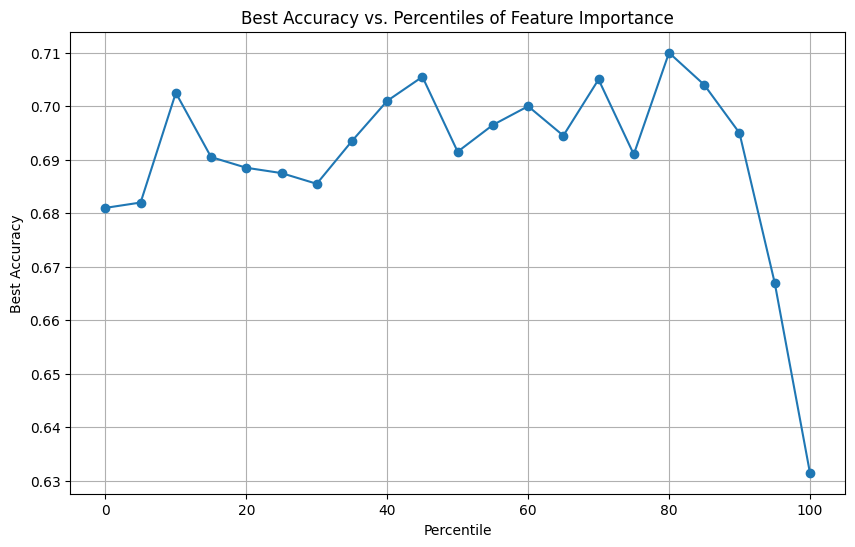

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

# Assume the following variables are defined from your previous code:
# data, y_second, preprocessor_second, feature_importance, best_hps, features_to_remove

# Convert feature importance values to numpy array
importance_values = np.array(list(feature_importance.values()))
feature_names = preprocessor_second.get_feature_names_out()

# Add the p0, p1, p2 features if needed
aux_features = ['num__p0', 'num__p1', 'num__p2', 'num__p3', 'num__p4', 'num__p5']

# Define the percentiles from all features (0%) to 100% in increments of 5%
percentiles = np.arange(0, 101, 5)

best_accuracies = []
    
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

for perc in percentiles:
    # Determine threshold
    threshold = np.percentile(importance_values, perc)
    
    # Select features above this threshold
    selected_features = [feature for feature, score in feature_importance.items() if score >= threshold]
    
    # Add auxiliary features if they are available and not already included
    for aux_feat in aux_features:
        if aux_feat in feature_names and aux_feat not in selected_features:
            selected_features.append(aux_feat)
    
    # Prepare the data with selected features
    selected_indices = [list(feature_names).index(feat) for feat in selected_features]
    
    # Transform the entire dataset again
    X_second_processed_full = preprocessor_second.transform(data[second_stage_features])
    X_final = X_second_processed_full[:, selected_indices]
    
    # Split the data
    X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
        X_final,
        y_second,
        test_size=0.2,
        random_state=77
    )

    # Build the model with the best hyperparameters
    model = build_model(best_hps)

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

    # Retrain the model and capture the history
    history = model.fit(
        X_train_final,
        y_train_final,
        epochs=500,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )
    
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test_final, y_test_final, verbose=0)
    best_accuracies.append(accuracy)
    print(f"Percentile: {perc}, Features: {len(selected_features)}, Test Accuracy: {accuracy:.4f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(percentiles, best_accuracies, marker='o')
plt.title('Best Accuracy vs. Percentiles of Feature Importance')
plt.xlabel('Percentile')
plt.ylabel('Best Accuracy')
plt.grid(True)
plt.show()

Color Palette (RGB values): [(0.24715576253545807, 0.49918708160096675, 0.5765599057376697), (0.2525741242463334, 0.5026993808626472, 0.5794992095664446), (0.25799248595720875, 0.5062116801243278, 0.5824385133952195), (0.2634108476680841, 0.5097239793860082, 0.5853778172239944), (0.2742475710898348, 0.5167485779093692, 0.5912564248815443), (0.27966593280071017, 0.5202608771710497, 0.5941957287103192), (0.28508429451158546, 0.5237731764327302, 0.5971350325390942), (0.2959210179333362, 0.5307977749560913, 0.603013640196644), (0.3013393796442115, 0.5343100742177718, 0.6059529440254189), (0.3067577413550869, 0.5378223734794522, 0.6088922478541938), (0.3121761030659622, 0.5413346727411328, 0.6118315516829688), (0.3230128264877129, 0.5483592712644937, 0.6177101593405185), (0.32843118819858824, 0.5518715705261742, 0.6206494631692935), (0.3338495499094636, 0.5553838697878547, 0.6235887669980685), (0.34468627333121427, 0.5624084683112157, 0.6294673746556183), (0.3501046350420896, 0.565920767572

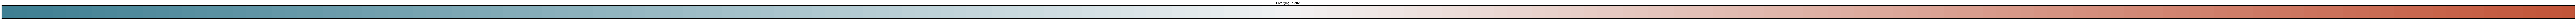

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the diverging palette
palette = sns.diverging_palette(220, 20, n=200)
color_palette = ['#D3D3D3', '#59858B', '#6A92C2', '#90BC95', '#A9CA9E', '#D7DEC0']

# Print the RGB values of the palette
print("Color Palette (RGB values):", palette)

# Optional: Convert RGB to Hex
def rgb_to_hex(rgb):
    return "#{:02x}{:02x}{:02x}".format(int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))

hex_palette = [rgb_to_hex(color) for color in palette]
print("Color Palette (Hex values):", hex_palette)

# Visualize the palette
sns.palplot(palette)
plt.title("Diverging Palette")
plt.show()

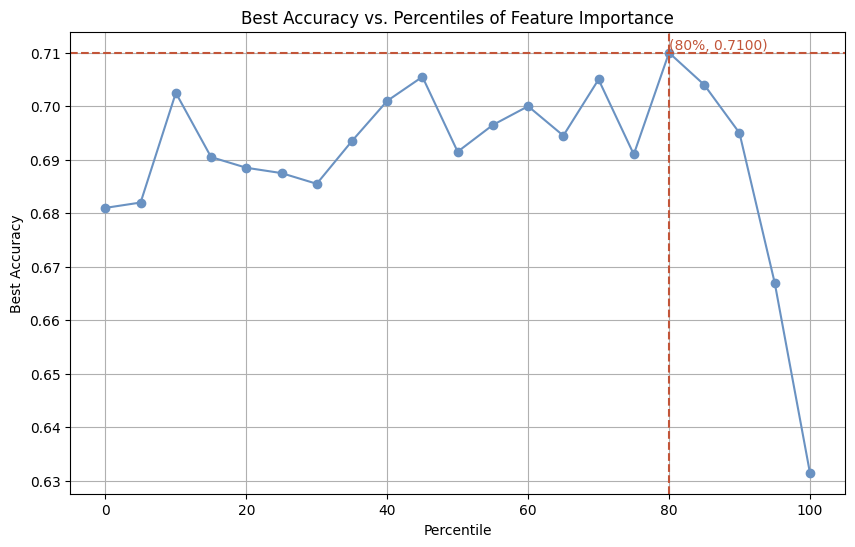

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have run the loop and have percentiles and best_accuracies arrays
# percentiles = ...
# best_accuracies = ...

# Find the index of the maximum accuracy
max_idx = np.argmax(best_accuracies)
max_percentile = percentiles[max_idx]
max_accuracy = best_accuracies[max_idx]

plt.figure(figsize=(10, 6))
plt.plot(percentiles, best_accuracies, marker='o', color=color_palette[2])

# Draw red dashed lines at the max accuracy point
plt.axvline(x=max_percentile, color=hex_palette[len(hex_palette)-1], linestyle='--')
plt.axhline(y=max_accuracy, color=hex_palette[len(hex_palette)-1], linestyle='--')

plt.title('Best Accuracy vs. Percentiles of Feature Importance')
plt.xlabel('Percentile')
plt.ylabel('Best Accuracy')
plt.grid(True)

# Optionally, add a text annotation to describe the point
plt.text(max_percentile, max_accuracy, f"({max_percentile}%, {max_accuracy:.4f})",
         ha='left', va='bottom', color=hex_palette[len(hex_palette)-1], fontsize=10)

plt.show()


Epoch 1/500


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - accuracy: 0.6594 - loss: 0.6023 - val_accuracy: 0.6919 - val_loss: 0.5654 - learning_rate: 0.0010
Epoch 2/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - accuracy: 0.7026 - loss: 0.5615 - val_accuracy: 0.6931 - val_loss: 0.5695 - learning_rate: 0.0010
Epoch 3/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - accuracy: 0.7055 - loss: 0.5572 - val_accuracy: 0.6988 - val_loss: 0.5755 - learning_rate: 0.0010
Epoch 4/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - accuracy: 0.7150 - loss: 0.5498 - val_accuracy: 0.6981 - val_loss: 0.5660 - learning_rate: 0.0010
Epoch 5/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - accuracy: 0.7138 - loss: 0.5500 - val_accuracy: 0.7013 - val_loss: 0.5683 - learning_rate: 0.0010
Epoch 6/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - accuracy: 0.7158 - loss: 0.5401 - val_accuracy: 0.6963 - val_loss: 0.5682 - learning_rate: 0.0010
Epoch 7/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - accuracy: 0.7285 - loss: 

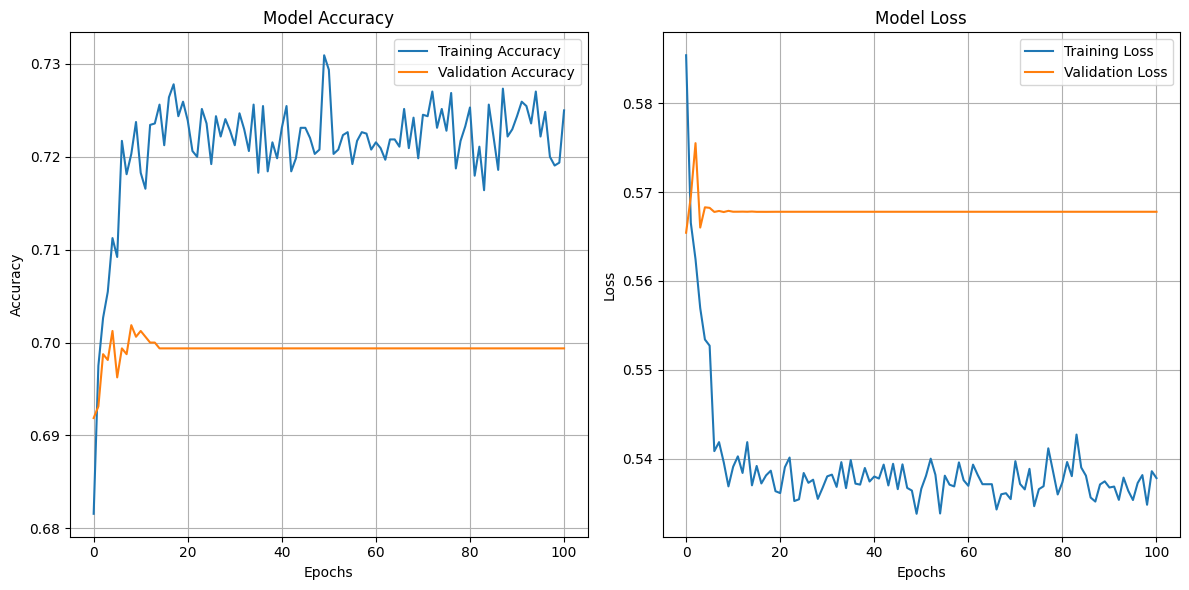

In [99]:
perc = 80

threshold = np.percentile(importance_values, perc)
    
# Select features above this threshold
selected_features = [feature for feature, score in feature_importance.items() if score >= threshold]
    
# Add auxiliary features if they are available and not already included
for aux_feat in aux_features:
    if aux_feat in feature_names and aux_feat not in selected_features:
        selected_features.append(aux_feat)
    
# Prepare the data with selected features
selected_indices = [list(feature_names).index(feat) for feat in selected_features]
    
# Transform the entire dataset again
X_second_processed_full = preprocessor_second.transform(data[second_stage_features])
X_final = X_second_processed_full[:, selected_indices]
    
# Split the data
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_final,
    y_second,
    test_size=0.2,
    random_state=77
)

# Build the model with the best hyperparameters
model = build_model(best_hps)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Retrain the model and capture the history
history = model.fit(
    X_train_final,
    y_train_final,
    epochs=500,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
    
# Evaluate the model
loss, accuracy = model.evaluate(X_test_final, y_test_final, verbose=0)
    
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions
y_pred_probs = model.predict(X_test_final).flatten()
y_pred = (y_pred_probs >= 0.5).astype(int)

# Classification report
print(classification_report(y_test_final, y_pred, target_names=['Survived', 'Died']))

# Now you can plot the training history
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()



Optimal Threshold (Highest Test Accuracy): 0.52
Test Accuracy at Optimal Threshold: 0.7010
              precision    recall  f1-score   support

    Survived       0.68      0.70      0.69       942
        Died       0.73      0.70      0.71      1058

    accuracy                           0.70      2000
   macro avg       0.70      0.70      0.70      2000
weighted avg       0.70      0.70      0.70      2000



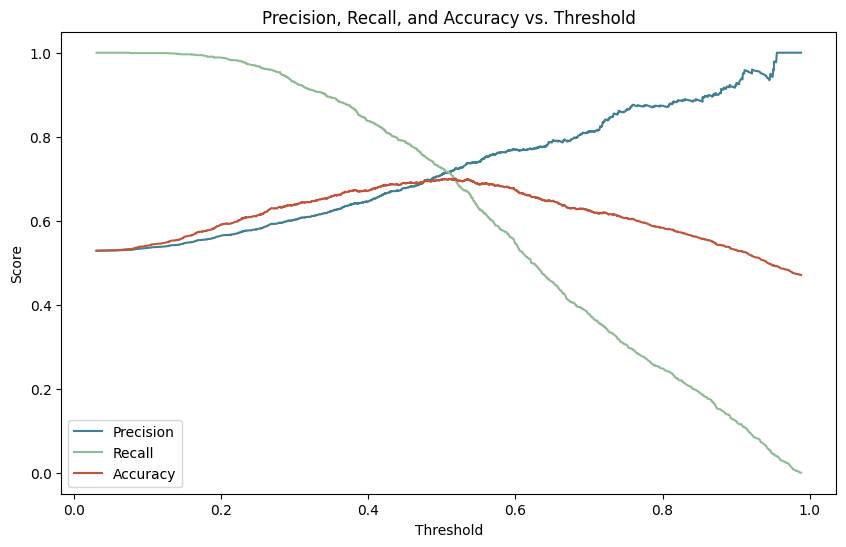

In [84]:
from sklearn.metrics import accuracy_score, precision_recall_curve
from math import floor
# Compute precision-recall pairs and thresholds
precision, recall, thresholds = precision_recall_curve(y_test_final, y_pred_probs)

# Compute accuracy for each threshold
accuracies = []
for threshold in thresholds:
    y_pred = (y_pred_probs >= threshold).astype(int)
    accuracies.append(accuracy_score(y_test_final, y_pred))

# Find the optimal threshold based on maximum test accuracy
optimal_idx = np.argmax(accuracies)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold (Highest Test Accuracy): {optimal_threshold:.2f}")
print(f"Test Accuracy at Optimal Threshold: {accuracies[optimal_idx]:.4f}")

# Use the optimal threshold for predictions
y_pred = (y_pred_probs >= optimal_threshold).astype(int)

# Print classification report
print(classification_report(y_test_final, y_pred, target_names=['Survived', 'Died']))

# Plot precision, recall, and accuracy vs. threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color = hex_palette[1])
plt.plot(thresholds, recall[:-1], label='Recall', color = color_palette[3])
plt.plot(thresholds, accuracies, label='Accuracy', color = hex_palette[len(hex_palette)-1])
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and Accuracy vs. Threshold')
plt.legend()
plt.show()


In [85]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, labels=['Survived', 'Died'], vmax=500, vmin=100, title='Confusion Matrix'):
    """
    Plots a confusion matrix with a diverging color palette.
    
    Args:
        cm (np.array): Confusion matrix (2D array).
        labels (list): List of labels for the confusion matrix axes. Default is None.
        vmax (int): Maximum value for color scaling. Default is 500.
        vmin (int): Minimum value for color scaling. Default is 100.
        title (str): Title of the confusion matrix plot. Default is 'Confusion Matrix'.
    """
    # Create a figure
    plt.figure(figsize=(10, 8))
    
    # Create heatmap
    sns.heatmap(cm, 
                annot=True, 
                fmt='d',
                cmap=sns.diverging_palette(220, 20, n=200),
                vmin=vmin,
                vmax=vmax,
                center=(vmax + vmin) / 2,
                square=True,
                xticklabels=labels if labels else ['Class 0', 'Class 1'],
                yticklabels=labels if labels else ['Class 0', 'Class 1'])

    # Customize the plot
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Rotate tick labels for better readability
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.show()


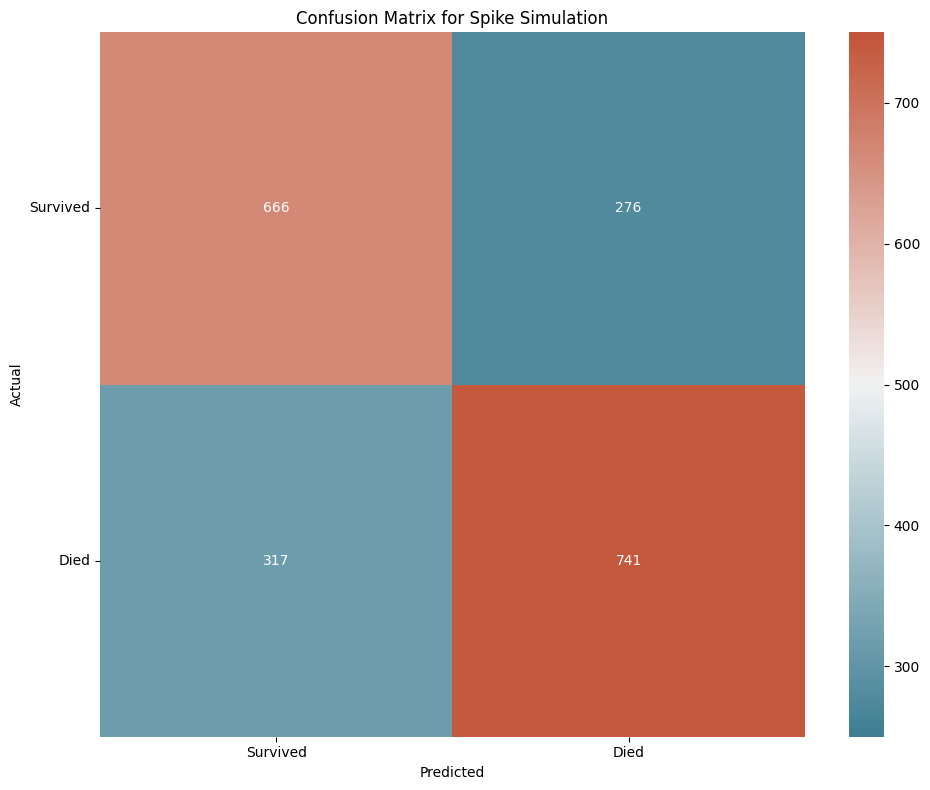

In [102]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.colors import LinearSegmentedColormap

# Confusion matrix
custom_palette = sns.diverging_palette(220, 10, n=20, as_cmap=False)
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_palette, N=200)
cm = confusion_matrix(y_test_final, y_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Survived', 'Died'])
#disp.plot(cmap=custom_cmap)
plot_confusion_matrix(cm, vmax=750, vmin=250, title="Confusion Matrix for Spike Simulation")

## Save Results


In [103]:
import pandas as pd
import numpy as np

# 4. Make predictions on the entire dataset
y_pred_probs_full = model.predict(X_final).flatten()
y_pred_full = (y_pred_probs_full >= optimal_threshold).astype(int)

# 5. Append predictions to the original dataset
data_with_predictions = data.copy()
data_with_predictions['predicted_mortality_probability'] = y_pred_probs_full
data_with_predictions['predicted_mortality'] = y_pred_full

# 6. Save the updated dataset
data_with_predictions.to_csv('Spike_sim_data_with_mortality_predictions_TE.csv', index=False)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step


## LASSO Regularization

In [53]:
best_hps.values

{'num_layers': 3,
 'units_0': 128,
 'batch_norm_0': False,
 'activation_0': 'sigmoid',
 'dropout_0': 0.0,
 'optimizer': 'rmsprop',
 'units_1': 256,
 'batch_norm_1': False,
 'activation_1': 'tanh',
 'dropout_1': 0.1,
 'units_2': 160,
 'batch_norm_2': True,
 'activation_2': 'tanh',
 'dropout_2': 0.0,
 'units_3': 160,
 'batch_norm_3': False,
 'activation_3': 'sigmoid',
 'dropout_3': 0.2,
 'units_4': 256,
 'batch_norm_4': False,
 'activation_4': 'relu',
 'dropout_4': 0.0}

Epoch 1/500


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5968 - loss: 3.1961 - val_accuracy: 0.6694 - val_loss: 1.7879 - learning_rate: 0.0010
Epoch 2/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - accuracy: 0.6886 - loss: 1.5132 - val_accuracy: 0.6900 - val_loss: 0.9588 - learning_rate: 0.0010
Epoch 3/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.7062 - loss: 0.8914 - val_accuracy: 0.6906 - val_loss: 0.7797 - learning_rate: 0.0010
Epoch 4/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.7147 - loss: 0.7394 - val_accuracy: 0.6900 - val_loss: 0.7243 - learning_rate: 0.0010
Epoch 5/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.7205 - loss: 0.6933 - val_accuracy: 0.6925 - val_loss: 0.6987 - learning_rate: 0.0010
Epoch 6/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - accuracy: 0.7223 - loss: 0.6702 - val_accuracy: 0.6850 - val_loss: 0.6874 - learning_rate: 0.0010
Epoch 7/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - accuracy: 0.7288 - loss: 0.

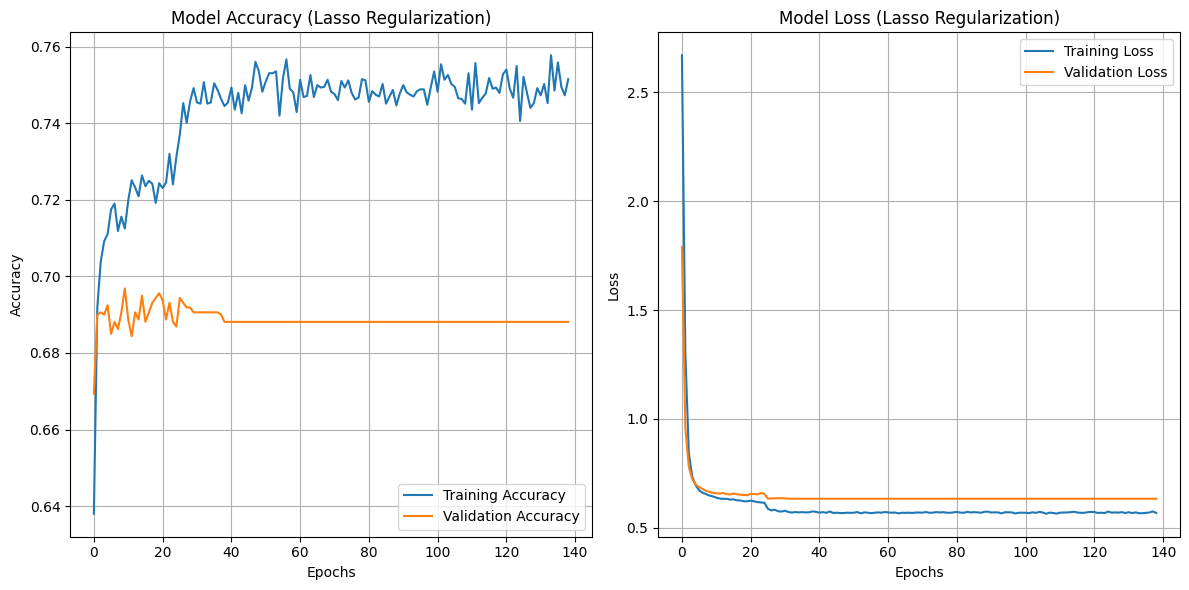

In [104]:
from tensorflow.keras import regularizers
perc = 0

threshold = np.percentile(importance_values, perc)
    
# Select features above this threshold
selected_features = [feature for feature, score in feature_importance.items() if score >= threshold]
    
# Add auxiliary features if they are available and not already included
for aux_feat in aux_features:
    if aux_feat in feature_names and aux_feat not in selected_features:
        selected_features.append(aux_feat)
    
# Prepare the data with selected features
selected_indices = [list(feature_names).index(feat) for feat in selected_features]
    
# Transform the entire dataset again
X_second_processed_full = preprocessor_second.transform(data[second_stage_features])
X_final = X_second_processed_full[:, selected_indices]
    
# Split the data
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_final,
    y_second,
    test_size=0.2,
    random_state=77
)

def build_model_with_lasso(hp, l1_lambda=1e-3):
    model = Sequential()
    num_layers = hp.get('num_layers')
    
    for i in range(num_layers):
        units = hp.get(f'units_{i}')
        activation = hp.get(f'activation_{i}')
        use_batch_norm = hp.get(f'batch_norm_{i}')
        dropout_rate = hp.get(f'dropout_{i}')
        
        if i == 0:
            model.add(Dense(units,
                            input_shape=(X_train_final.shape[1],),
                            kernel_regularizer=regularizers.l1(l1_lambda)))
        else:
            model.add(Dense(units, kernel_regularizer=regularizers.l1(l1_lambda)))
        
        if use_batch_norm:
            model.add(BatchNormalization())
        
        model.add(Activation(activation))
        
        if dropout_rate > 0.0:
            model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = hp.get('optimizer')
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build the model using best_hps but with L1 regularization
model = build_model_with_lasso(best_hps, l1_lambda=1e-3)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Retrain the model and capture the history
history = model.fit(
    X_train_final,
    y_train_final,
    epochs=500,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_final, y_test_final, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions
y_pred_probs = model.predict(X_test_final).flatten()
y_pred = (y_pred_probs >= 0.5).astype(int)

# Classification report
print(classification_report(y_test_final, y_pred, target_names=['Survived', 'Died']))

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (Lasso Regularization)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Lasso Regularization)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Optimal Threshold (Highest Test Accuracy): 0.46
Test Accuracy at Optimal Threshold: 0.6975
              precision    recall  f1-score   support

    Survived       0.70      0.62      0.66       942
        Died       0.69      0.77      0.73      1058

    accuracy                           0.70      2000
   macro avg       0.70      0.69      0.69      2000
weighted avg       0.70      0.70      0.70      2000



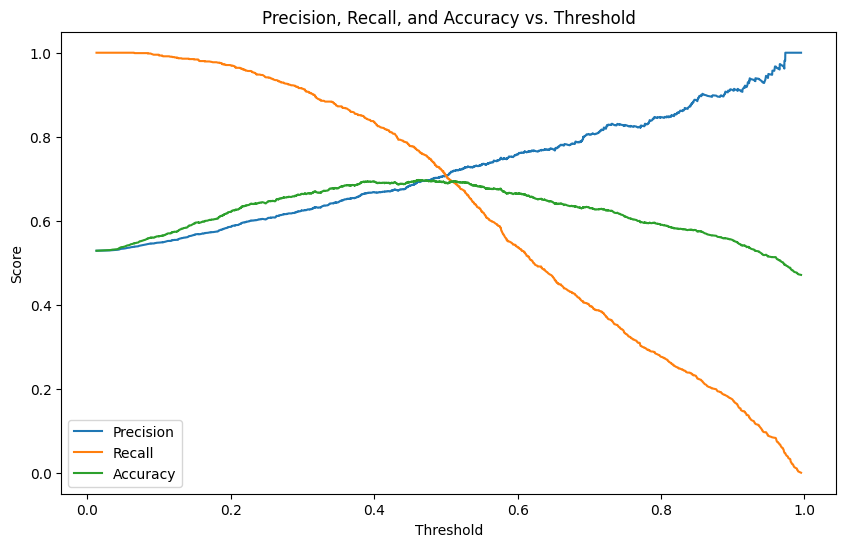

In [105]:
from sklearn.metrics import accuracy_score, precision_recall_curve

# Compute precision-recall pairs and thresholds
precision, recall, thresholds = precision_recall_curve(y_test_final, y_pred_probs)

# Compute accuracy for each threshold
accuracies = []
for threshold in thresholds:
    y_pred = (y_pred_probs >= threshold).astype(int)
    accuracies.append(accuracy_score(y_test_final, y_pred))

# Find the optimal threshold based on maximum test accuracy
optimal_idx = np.argmax(accuracies)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold (Highest Test Accuracy): {optimal_threshold:.2f}")
print(f"Test Accuracy at Optimal Threshold: {accuracies[optimal_idx]:.4f}")

# Use the optimal threshold for predictions
y_pred = (y_pred_probs >= optimal_threshold).astype(int)

# Print classification report
print(classification_report(y_test_final, y_pred, target_names=['Survived', 'Died']))

# Plot precision, recall, and accuracy vs. threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, accuracies, label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and Accuracy vs. Threshold')
plt.legend()
plt.show()


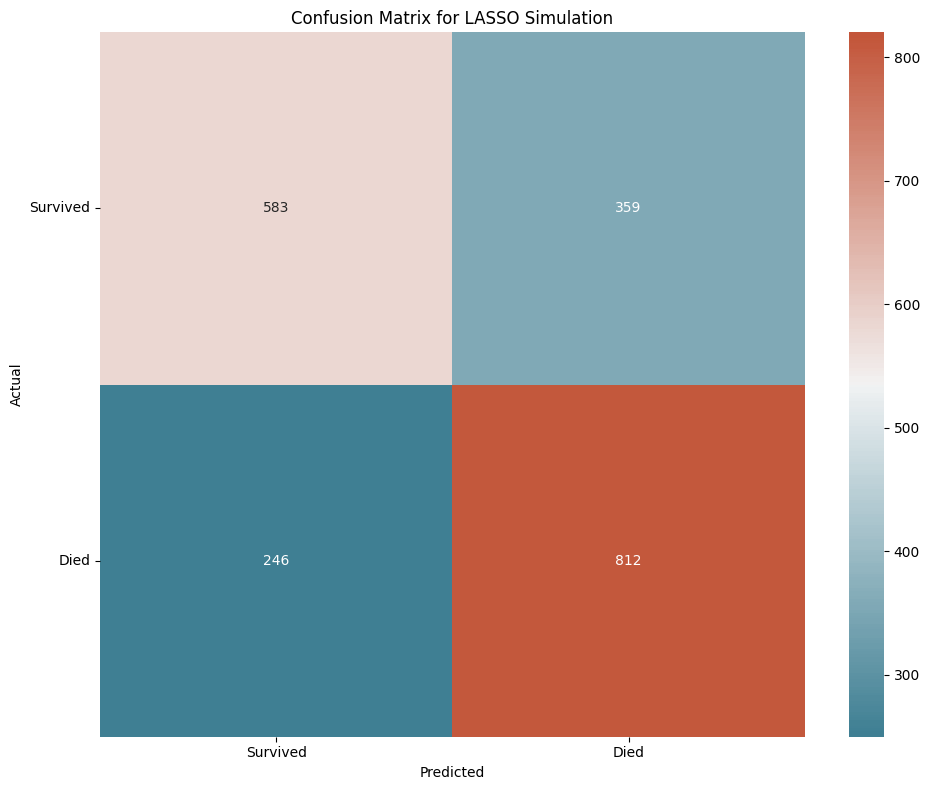

In [108]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(y_test_final, y_pred)
plot_confusion_matrix(cm, vmax=820, vmin=250, title="Confusion Matrix for LASSO Simulation")

In [90]:
# Predict on the entire dataset
y_pred_probs_full = model.predict(X_final).flatten()
y_pred_full = (y_pred_probs_full >= 0.5).astype(int)

# Append predictions to the original dataset
data_with_predictions = data.copy()
data_with_predictions['predicted_mortality_probability'] = y_pred_probs_full
data_with_predictions['predicted_mortality'] = y_pred_full

# Save the updated dataset
data_with_predictions.to_csv('LASSO_sim_data_with_mortality_predictions_TE.csv', index=False)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step


## Baysian LASSO

In [113]:
import pandas as pd

# Suppose your ranking file is 'feature_ranking.csv' with columns 'Feature' and 'Importance_Score'
ranking_df = pd.read_csv('/Applications/Harvard/sophomore1/bst228/proj/Data/analysis_75percentile_sim_results_TE.csv')

# Convert this into a dictionary: { 'Feature_0': score, 'Feature_1': score, ... }
feature_importance = dict(zip(ranking_df['Feature'], ranking_df['Importance_Score']))
importance_values = np.array(list(feature_importance.values()))

# Compute a threshold, e.g., top 25% features
threshold = np.percentile(importance_values, 25)

# Select features that meet or exceed the threshold
selected_features = [
    feature for feature, score in feature_importance.items() 
    if score >= threshold
]

print("Selected Features for Final Neural Network:", len(selected_features))
print(selected_features)
# Map from Feature_0 -> actual_feature_name_0, etc.
mapping = {f"Feature_{i}": orig_name for i, orig_name in enumerate(feature_names)}

# Now translate your selected features:
selected_features_original = [mapping[f] for f in selected_features]
print(selected_features_original)

Selected Features for Final Neural Network: 84
['Feature_0', 'Feature_2', 'Feature_1', 'Feature_3', 'Feature_6', 'Feature_5', 'Feature_4', 'Feature_9', 'Feature_105', 'Feature_7', 'Feature_8', 'Feature_100', 'Feature_103', 'Feature_30', 'Feature_111', 'Feature_89', 'Feature_104', 'Feature_59', 'Feature_93', 'Feature_61', 'Feature_44', 'Feature_63', 'Feature_107', 'Feature_23', 'Feature_70', 'Feature_22', 'Feature_56', 'Feature_73', 'Feature_106', 'Feature_32', 'Feature_88', 'Feature_95', 'Feature_42', 'Feature_65', 'Feature_38', 'Feature_54', 'Feature_35', 'Feature_80', 'Feature_16', 'Feature_20', 'Feature_12', 'Feature_24', 'Feature_66', 'Feature_110', 'Feature_13', 'Feature_10', 'Feature_14', 'Feature_39', 'Feature_76', 'Feature_19', 'Feature_55', 'Feature_62', 'Feature_36', 'Feature_45', 'Feature_57', 'Feature_77', 'Feature_68', 'Feature_34', 'Feature_60', 'Feature_11', 'Feature_90', 'Feature_74', 'Feature_49', 'Feature_81', 'Feature_33', 'Feature_15', 'Feature_71', 'Feature_86', 'F

Epoch 1/500


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.6049 - loss: 0.6564 - val_accuracy: 0.6756 - val_loss: 0.5847 - learning_rate: 0.0010
Epoch 2/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.6930 - loss: 0.5741 - val_accuracy: 0.6875 - val_loss: 0.5748 - learning_rate: 0.0010
Epoch 3/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - accuracy: 0.7122 - loss: 0.5555 - val_accuracy: 0.6819 - val_loss: 0.5763 - learning_rate: 0.0010
Epoch 4/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.7176 - loss: 0.5304 - val_accuracy: 0.6881 - val_loss: 0.5816 - learning_rate: 0.0010
Epoch 5/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - accuracy: 0.7334 - loss: 0.5223 - val_accuracy: 0.6831 - val_loss: 0.5778 - learning_rate: 0.0010
Epoch 6/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - accuracy: 0.7458 - loss: 0.5109 - val_accuracy: 0.6950 - val_loss: 0.5872 - learning_rate: 0.0010
Epoch 7/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - accuracy: 0.7593 - loss: 

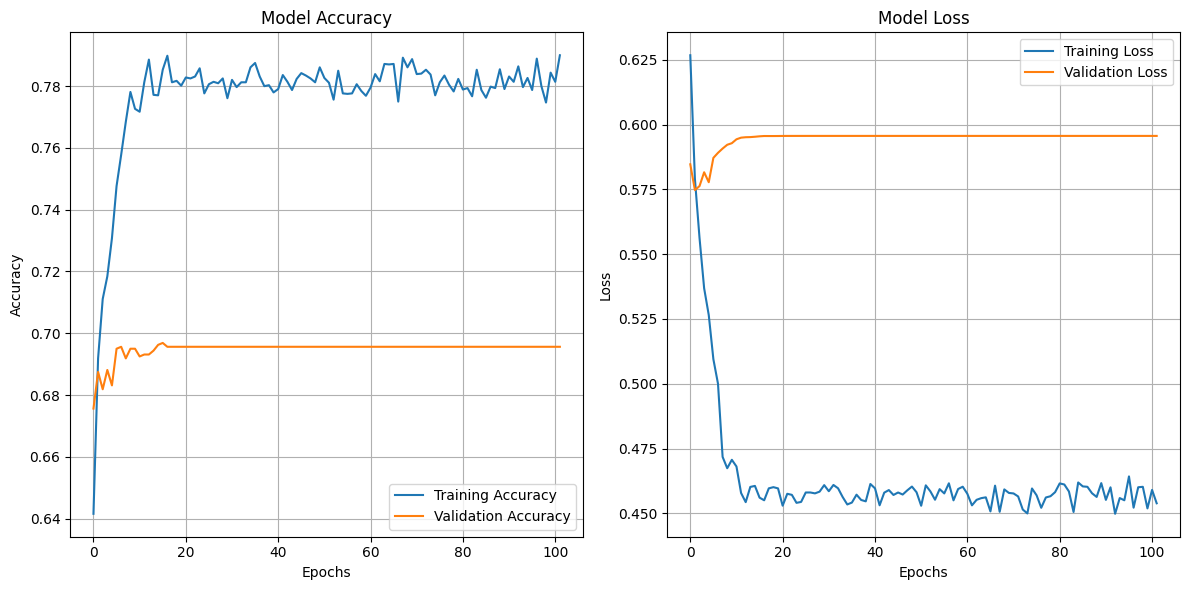

In [114]:
selected_features = selected_features_original
aux_features = ['num__p0', 'num__p1', 'num__p2', 'num__p3', 'num__p4', 'num__p5']
for aux_feat in aux_features:
    if aux_feat in feature_names and aux_feat not in selected_features:
        selected_features.append(aux_feat)
    
# Prepare the data with selected features
selected_indices = [list(feature_names).index(feat) for feat in selected_features]
    
# Transform the entire dataset again
X_second_processed_full = preprocessor_second.transform(data[second_stage_features])
X_final = X_second_processed_full[:, selected_indices]
    
# Split the data
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_final,
    y_second,
    test_size=0.2,
    random_state=77
)

# Build the model with the best hyperparameters
model = build_model(best_hps)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Retrain the model and capture the history
history = model.fit(
    X_train_final,
    y_train_final,
    epochs=500,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
    
# Evaluate the model
loss, accuracy = model.evaluate(X_test_final, y_test_final, verbose=0)
    
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions
y_pred_probs = model.predict(X_test_final).flatten()
y_pred = (y_pred_probs >= 0.5).astype(int)

# Classification report
print(classification_report(y_test_final, y_pred, target_names=['Survived', 'Died']))

# Now you can plot the training history
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()



Optimal Threshold (Highest Test Accuracy): 0.48
Test Accuracy at Optimal Threshold: 0.6945
              precision    recall  f1-score   support

    Survived       0.67      0.69      0.68       942
        Died       0.72      0.70      0.71      1058

    accuracy                           0.69      2000
   macro avg       0.69      0.69      0.69      2000
weighted avg       0.70      0.69      0.69      2000



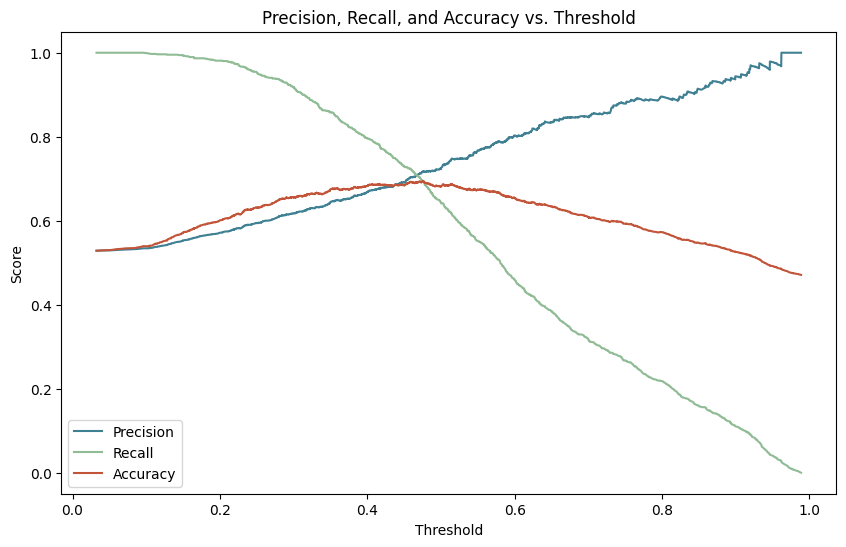

In [115]:
from sklearn.metrics import accuracy_score, precision_recall_curve
from math import floor
# Compute precision-recall pairs and thresholds
precision, recall, thresholds = precision_recall_curve(y_test_final, y_pred_probs)

# Compute accuracy for each threshold
accuracies = []
for threshold in thresholds:
    y_pred = (y_pred_probs >= threshold).astype(int)
    accuracies.append(accuracy_score(y_test_final, y_pred))

# Find the optimal threshold based on maximum test accuracy
optimal_idx = np.argmax(accuracies)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold (Highest Test Accuracy): {optimal_threshold:.2f}")
print(f"Test Accuracy at Optimal Threshold: {accuracies[optimal_idx]:.4f}")

# Use the optimal threshold for predictions
y_pred = (y_pred_probs >= optimal_threshold).astype(int)

# Print classification report
print(classification_report(y_test_final, y_pred, target_names=['Survived', 'Died']))

# Plot precision, recall, and accuracy vs. threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color = hex_palette[1])
plt.plot(thresholds, recall[:-1], label='Recall', color = color_palette[3])
plt.plot(thresholds, accuracies, label='Accuracy', color = hex_palette[len(hex_palette)-1])
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and Accuracy vs. Threshold')
plt.legend()
plt.show()


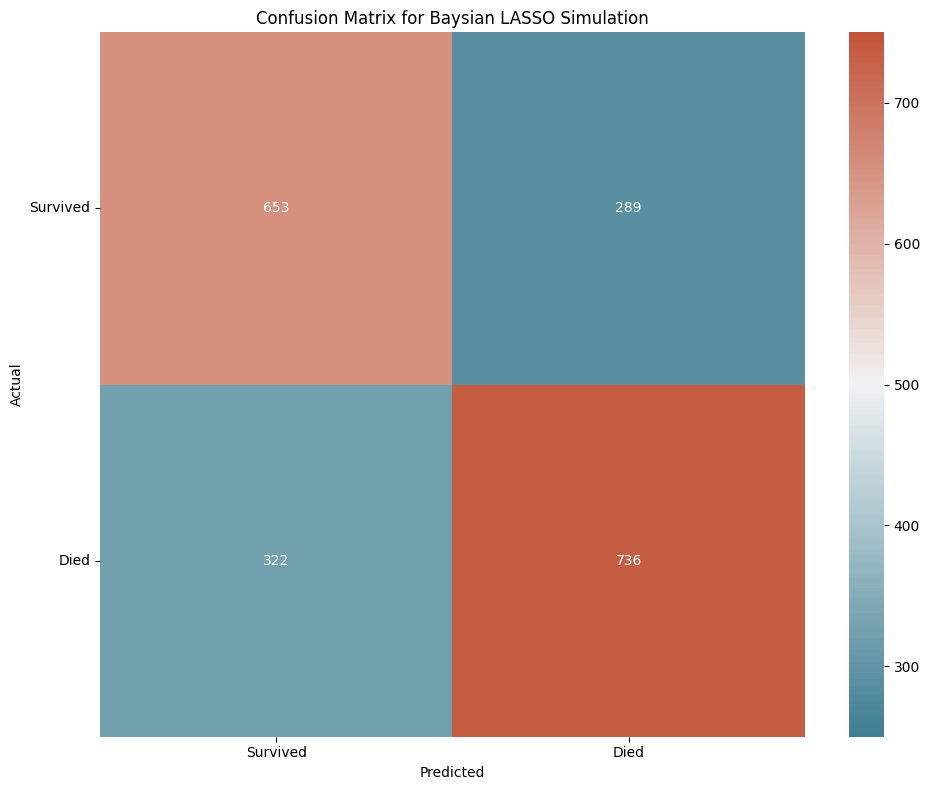

In [117]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(y_test_final, y_pred)
plot_confusion_matrix(cm, vmax=750, vmin=250, title="Confusion Matrix for Baysian LASSO Simulation")

In [44]:
sum(y_pred)

1999

In [95]:
# Predict on the entire dataset
y_pred_probs_full = model.predict(X_final).flatten()
y_pred_full = (y_pred_probs_full >= 0.5).astype(int)

# Append predictions to the original dataset
data_with_predictions = data.copy()
data_with_predictions['predicted_mortality_probability'] = y_pred_probs_full
data_with_predictions['predicted_mortality'] = y_pred_full

# Save the updated dataset
data_with_predictions.to_csv('BaysianLASSO_sim_data_with_mortality_predictions_TE.csv', index=False)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
